### PIVOT TABLES

 A pivot table is a similar operation(as groupby()) that is commonly seen in spreadsheets and
other programs that operate on tabular data. The pivot table takes simple columnwise 
data as input, and groups the entries into a two-dimensional table that provides
a multidimensional summarization of the data. The difference between pivot tables
and GroupBy can sometimes cause confusion; it helps me to think of pivot tables as
essentially a multidimensional version of GroupBy aggregation. That is, you splitapply-combine,
but both the split and the combine happen across not a onedimensional index, but across a two-dimensional grid.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
titanic=sns.load_dataset('titanic')
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [4]:
titanic.describe()

,survived,pclass,age,sibsp,parch,fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


### Pivot Tables by Hand

In [12]:
titanic.groupby('sex')[['survived']].mean() # double square bracket makes it look decent

,survived
sex,
female,0.742038
male,0.188908


In [13]:
titanic.groupby('sex')['survived'].mean() # just a difference of one square bracket 

sex
female    0.742038
male      0.188908
Name: survived, dtype: float64

Let's go a step deeper 

In [14]:
titanic.groupby(['sex','class'])['survived'].aggregate('mean').unstack() # Here the code becomes a bit messsy 
# Here is where pivot takes entry

class,First,Second,Third
sex,,,
female,0.968085,0.921053,0.500000
male,0.368852,0.157407,0.135447


This gives us a better idea of how both gender and class affected survival, but the
code is starting to look a bit garbled

#### Pivot Table Syntax

In [15]:
titanic.pivot_table('survived',index='sex',columns='class')
# This code on the other hand looks a little easy to understand

class,First,Second,Third
sex,,,
female,0.968085,0.921053,0.500000
male,0.368852,0.157407,0.135447


#### Multilevel pivot tables


In [16]:
age=pd.cut(titanic['age'],[0,18,80])
titanic.pivot_table('survived',['sex',age],'class')

class               First    Second     Third
sex    age                                   
female (0, 18]   0.909091  1.000000  0.511628
       (18, 80]  0.972973  0.900000  0.423729
male   (0, 18]   0.800000  0.600000  0.215686
       (18, 80]  0.375000  0.071429  0.133663

In [22]:
titanic.pivot_table('survived',[age,'sex'],[fare,'class']).unstack() # opened up the output

fare     (-0.001, 14.454]                                           \
class               First      Second               Third            
sex                female male female      male    female     male   
age                                                                  
(0, 18]               NaN  NaN   1.00  0.000000  0.714286  0.26087   
(18, 80]              NaN  0.0   0.88  0.098039  0.444444  0.12500   

fare     (14.454, 512.329]                                                    
class                First              Second               Third            
sex                 female      male    female      male    female      male  
age                                                                           
(0, 18]           0.909091  0.800000  1.000000  0.818182  0.318182  0.178571  
(18, 80]          0.972973  0.391304  0.914286  0.030303  0.391304  0.192308

The result is a four-dimensional aggregation with hierarchical indices, shown in a grid demonstrating the relationship between
the values.


### Additional pivot table options

The full call signature of the pivot_table method of DataFrames is as follows:

>DataFrame.pivot_table(data, values=None, index=None, columns=None,
 aggfunc='mean', fill_value=None, margins=False,
 dropna=True, margins_name='All')


The aggfunc keyword controls what type of aggregation is applied, which is a mean
by default

 As in the GroupBy, the aggregation specification can be a string representing 
 one of several common choices ('sum', 'mean', 'count', 'min', 'max', etc.) or a
function that implements an aggregation (np.sum(), min(), sum(), etc.)

In [27]:
titanic.pivot_table(index='sex',columns='class',aggfunc={'survived':sum,'fare':np.mean}) 
# instead of np.mean, 'mean' also works

fare                       survived             
class        First     Second      Third    First Second Third
sex                                                           
female  106.125798  21.970121  16.118810       91     70    72
male     67.226127  19.741782  12.661633       45     17    47

In [32]:
pd.DataFrame.pivot_table(titanic,index='sex',columns='class',aggfunc={'survived':sum,'fare':np.mean})  
# The above and this command works same

fare                       survived             
class        First     Second      Third    First Second Third
sex                                                           
female  106.125798  21.970121  16.118810       91     70    72
male     67.226127  19.741782  12.661633       45     17    47

Notice also here that we’ve omitted the values keyword; when you’re specifying a
mapping for aggfunc, this is determined automatically. In all the above examples 
we used 'survived' as values 

At times it’s useful to compute totals along each grouping. This can be done via the
margins keyword

In [34]:
titanic.pivot_table('survived',index='sex',columns='class',margins=True)

class,First,Second,Third,All
sex,,,,
female,0.968085,0.921053,0.500000,0.742038
male,0.368852,0.157407,0.135447,0.188908
All,0.629630,0.472826,0.242363,0.383838


Here this automatically gives us information about the class-agnostic survival rate by
gender, the gender-agnostic survival rate by class, and the overall survival rate of 38%.
The margin label can be specified with the margins_name keyword, which defaults to
"All".

### Example: Birthrate Data

In [37]:
link=r'https://raw.githubusercontent.com/jakevdp/data-CDCbirths/master/births.csv '
birth=pd.read_csv(link)
birth

,year,month,day,gender,births
0,1969,1,1.0,F,4046
1,1969,1,1.0,M,4440
2,1969,1,2.0,F,4454
3,1969,1,2.0,M,4548
4,1969,1,3.0,F,4548
...,...,...,...,...,...
15542,2008,10,NaN,M,183219
15543,2008,11,NaN,F,158939
15544,2008,11,NaN,M,165468
15545,2008,12,NaN,F,173215


In [49]:
import pandas as pd
import io
import requests

url="https://raw.githubusercontent.com/jakevdp/data-CDCbirths/master/births.csv"
s=requests.get(url).content
c=pd.read_csv(io.StringIO(s.decode('utf-8')))
c

,year,month,day,gender,births
0,1969,1,1.0,F,4046
1,1969,1,1.0,M,4440
2,1969,1,2.0,F,4454
3,1969,1,2.0,M,4548
4,1969,1,3.0,F,4548
...,...,...,...,...,...
15542,2008,10,NaN,M,183219
15543,2008,11,NaN,F,158939
15544,2008,11,NaN,M,165468
15545,2008,12,NaN,F,173215


 Let’s add a decade column, and take a look at male and female births as a function of decade

In [50]:
birth['decade']=10*(birth['year']//10)
birth.pivot_table('births',index='decade',columns='gender', aggfunc='sum')

gender,F,M
decade,,
1960,1753634,1846572
1970,16263075,17121550
1980,18310351,19243452
1990,19479454,20420553
2000,18229309,19106428


We immediately see that male births outnumber female births in every decade. To see
this trend a bit more clearly, we can use the built-in plotting tools in Pandas to 
visualize the total number of births by year

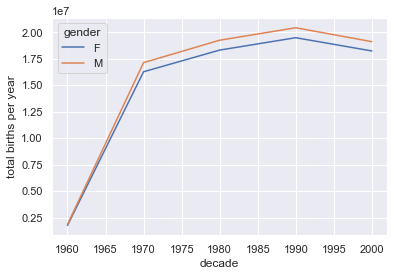

In [52]:
%matplotlib inline
import matplotlib.pyplot as plt
sns.set()
birth.pivot_table('births',index='decade',columns='gender', aggfunc='sum').plot()
plt.ylabel('total births per year');

With a simple pivot table and plot() method, we can immediately see the annual
trend in births by gender

### Further data exploration

In [88]:
quartiles=np.percentile(birth['births'],[25,50,75])
mu=quartiles[1]
sig=0.74*(quartiles[2]-quartiles[0])

In [92]:
print(quartiles);print(mu);print(sig)

[4383. 4812. 5259.]
4812.0
648.24


This final line is a robust estimate of the sample mean, where the 0.74 comes from the
interquartile range of a Gaussian distribution.

In [93]:
pd.to_datetime?

In [77]:
birth = birth.query('(births > @mu - 5 * @sig) & (births < @mu + 5 * @sig)')
birth

,year,month,day,gender,births,decade
0,1969,1,1.0,F,4046,1960
1,1969,1,1.0,M,4440,1960
2,1969,1,2.0,F,4454,1960
3,1969,1,2.0,M,4548,1960
4,1969,1,3.0,F,4548,1960
...,...,...,...,...,...,...
15062,1988,12,29.0,M,5944,1980
15063,1988,12,30.0,F,5742,1980
15064,1988,12,30.0,M,6095,1980
15065,1988,12,31.0,F,4435,1980


In [78]:
# set 'day' column to integer; it originally was a string due to nulls
birth['day'] = birth['day'].astype(int)

Finally, we can combine the day, month, and year to create a Date index 

In [80]:
# create a datetime index from the year, month, day
birth.index = pd.to_datetime(10000 * birth.year +
 100 * birth.month +
 birth.day, format='%Y%m%d')
birth['dayofweek'] = birth.index.dayofweek


In [118]:
pd.set_option('display.max_rows',10)

In [125]:
pd.to_datetime(10000*birth.year+100*birth.month+birth.day,format='%Y%m%d')
# This 10000,100 represents the unit place from where year or month should begin from 
# like in 1869 
        #   unit place of 9 is 1, uit place of 6 is 10s, unit plcae of 8 is 100 and that of 1 is 1000 

1969-01-01   1969-01-01
1969-01-01   1969-01-01
1969-01-02   1969-01-02
1969-01-02   1969-01-02
1969-01-03   1969-01-03
                ...    
1988-12-29   1988-12-29
1988-12-30   1988-12-30
1988-12-30   1988-12-30
1988-12-31   1988-12-31
1988-12-31   1988-12-31
Length: 14610, dtype: datetime64[ns]

In [128]:
birth.index.dayofweek


Int64Index([2, 2, 3, 3, 4, 4, 5, 5, 6, 6,
            ...
            1, 1, 2, 2, 3, 3, 4, 4, 5, 5],
           dtype='int64', length=14610)

In [129]:
birth # birth['dayofweek']=bith.dayofweek assigns the day of week to birth dates

,year,month,day,gender,births,decade,dayofweek
1969-01-01,1969,1,1,F,4046,1960,2
1969-01-01,1969,1,1,M,4440,1960,2
1969-01-02,1969,1,2,F,4454,1960,3
1969-01-02,1969,1,2,M,4548,1960,3
1969-01-03,1969,1,3,F,4548,1960,4
...,...,...,...,...,...,...,...
1988-12-29,1988,12,29,M,5944,1980,3
1988-12-30,1988,12,30,F,5742,1980,4
1988-12-30,1988,12,30,M,6095,1980,4
1988-12-31,1988,12,31,F,4435,1980,5


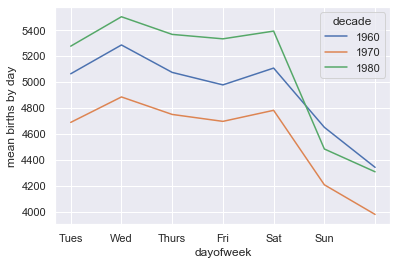

In [102]:
import matplotlib.pyplot as plt
import matplotlib as mpl
birth.pivot_table('births', index='dayofweek',
                    columns='decade', aggfunc='mean').plot()
plt.gca().set_xticklabels(['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'])
plt.ylabel('mean births by day');

Another interesting view is to plot the mean number of births by the day of the year.
Let’s first group the data by month and day separately

In [143]:
birth_by_date=birth.pivot_table('births',['month','day'])
birth_by_date

births
month day          
1     1    4009.225
      2    4247.400
      3    4500.900
      4    4571.350
      5    4603.625
...             ...
12    27   4850.150
      28   5044.200
      29   5120.150
      30   5172.350
      31   4859.200

[366 rows x 1 columns]

In [161]:
births_by_date = birth.pivot_table('births',
                                    [birth.index.month, birth.index.day])
births_by_date
# This and the above command gives same output

births
1  1   4009.225
   2   4247.400
   3   4500.900
   4   4571.350
   5   4603.625
...         ...
12 27  4850.150
   28  5044.200
   29  5120.150
   30  5172.350
   31  4859.200

[366 rows x 1 columns]

The result is a multi-index over months and days. To make this easily plottable, let’s
turn these months and days into a date by associating them with a dummy year vari‐
able

In [162]:
birth_by_date.index=[pd.datetime(2012,month,day)  # in the above birth_by_date we have not chosen index
                    for (month,day) in births_by_date.index]
birth_by_date

C:\Users\gdg13\anaconda\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  


,births
2012-01-01,4009.225
2012-01-02,4247.400
2012-01-03,4500.900
2012-01-04,4571.350
2012-01-05,4603.625
...,...
2012-12-27,4850.150
2012-12-28,5044.200
2012-12-29,5120.150
2012-12-30,5172.350


In [150]:
import datetime as dt # the above code statement says that it will be abrogated from next version onwards .
# Hence I should start using this datetime module instead

In [152]:
dir(dt)

['MAXYEAR',
 'MINYEAR',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'date',
 'datetime',
 'datetime_CAPI',
 'sys',
 'time',
 'timedelta',
 'timezone',
 'tzinfo']

In [160]:
dt.date(1999,5,13)

datetime.date(1999, 5, 13)

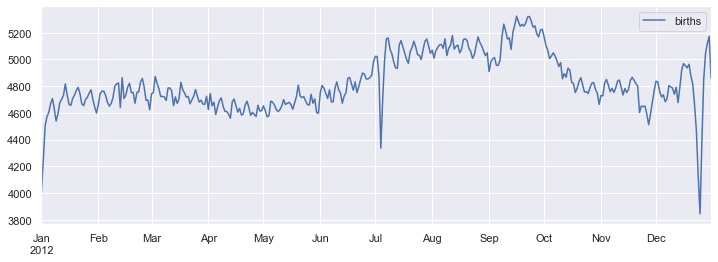

In [164]:
fig, ax = plt.subplots(figsize=(12, 4))
birth_by_date.plot(ax=ax)

In [165]:
birth_by_date

,births
2012-01-01,4009.225
2012-01-02,4247.400
2012-01-03,4500.900
2012-01-04,4571.350
2012-01-05,4603.625
...,...
2012-12-27,4850.150
2012-12-28,5044.200
2012-12-29,5120.150
2012-12-30,5172.350


### VECTORIZED STRING OPERATION

One strength of Python is its relative ease in handling and manipulating string data.
Pandas builds on this and provides a comprehensive set of vectorized string operations
that become an essential piece of the type of munging required when one is working
with (read: cleaning up) real-world data

#### Introducing Pandas String Operations


In [166]:
import numpy as np  # This is a vectorized performance and is faster then general calculation 
x = np.array([2, 3, 5, 7, 11, 13])
x * 2

array([ 4,  6, 10, 14, 22, 26])

 For arrays of strings, NumPy does not provide such simple
access, and thus you’re stuck using a more verbose loop syntax

In [2]:
data = ['peter', 'Paul', 'MARY', 'gUIDO']
[s.capitalize() for s in data] # returns the copy of data with 1st letter capitalized and rest in small letters

['Peter', 'Paul', 'Mary', 'Guido']

 This is perhaps sufficient to work with some data, but it will break if there are any
missing values

In [169]:
data = ['peter', 'Paul',None, 'MARY', 'gUIDO'] # just one none gives the error
[s.capitalize() for s in data]

AttributeError: 'NoneType' object has no attribute 'capitalize'

In [3]:
x=pd.Series(data)
x=x.dropna()
x.str.capitalize() # DataFrame has no attribute str , hence converted this to series

0    Peter
1     Paul
2     Mary
3    Guido
dtype: object

In [4]:
[s.capitalize() for s in x]  # It can also work this way

['Peter', 'Paul', 'Mary', 'Guido']

### Tables of Pandas String Methods

If you have a good understanding of string manipulation in Python, most of Pandas’
string syntax is intuitive enough

In [25]:
monte = pd.Series(['Graham Chapman', 'John Cleese robert', 'Terry Giliam',
 'Eric Idle', 'Terry Jones', 'Michael Palin'])

In [6]:
monte.str.lower() # lower() returns a series of strings with all lower initial values

0        graham chapman
1    john cleese robert
2          terry giliam
3             eric idle
4           terry jones
5         michael palin
dtype: object

In [225]:
for s in monte:  # Here split doesn't perform well 
    s.split()
    print(s)

Graham Chapman
John Cleese
Terry Gilliam
Eric Idle
Terry Jones
Michael Palin


In [226]:
monte.str.split()  # This is perfect split

0    [Graham, Chapman]
1       [John, Cleese]
2     [Terry, Gilliam]
3         [Eric, Idle]
4       [Terry, Jones]
5     [Michael, Palin]
dtype: object

### Methods using regular expressions

In addition, there are several methods that accept regular expressions to examine the
content of each string element, and follow some of the API conventions of Python’s
built-in re module

In [227]:
monte.str.extract?

In [12]:
monte.str.extract('([A-Za-z]+..)') # using only A-Z gives first capital letter of every string
# It just prints first capital letter , be it in first name or second name 
# no. of dots gives no. of letters followed by specified letters in bracket

,0
0,Graham C
1,John C
2,Terry G
3,Eric I
4,Terry J
5,Michael P


In [11]:
monte.str.extract('([A-Za-z].+)') # dot before + sign askss to print next word after space arrives and the next letter begins

,0
0,Graham Chapman
1,John Cleese robert
2,Terry Giliam
3,Eric Idle
4,Terry Jones
5,Michael Palin


In [311]:
monte.str.extract('([A-Z]..)')  #  . before + stands for space and . after + stands for alphabet

,0
0,Gra
1,Joh
2,Ter
3,Eri
4,Ter
5,Mic


In [17]:
monte.str.extract('([A-Za-z]+)') # This gives all the letters in the string

,0
0,Graham
1,John
2,Terry
3,Eric
4,Terry
5,Michael


In [253]:
monte.str.extract('([A-Za-z ]+)') # including a space after A-Za-z gives whole string
# Even if there are two spaces then also they are printed

,0
0,Graham Chapman
1,John Cleese robert
2,Terry Gilliam
3,Eric Idle
4,Terry Jones
5,Michael Palin


Or we can do something more complicated, like finding all names that start and end
with a consonant, making use of the start-of-string (^) and end-of-string ($) regular
expression characters

Or we can do something more complicated, like finding all names that start and end
with a consonant, making use of the start-of-string (^) and end-of-string ($) regular
expression characters

In [39]:
monte.str.findall(r'^[^AEIOU].*[^aeiou]$')  
# Acc to me ^represents start of the string and $ represents end of the string


0        [Graham Chapman]
1    [John Cleese robert]
2          [Terry Giliam]
3                      []
4           [Terry Jones]
5         [Michael Palin]
dtype: object

In [40]:
monte.str.findall?

### Miscellaneous methods

#### Vectorized item access and slicing

The get() and slice() operations, in particular,
enable vectorized element access from each array. For example, we can get a slice of
the first three characters of each array using str.slice(0, 3)

In [48]:
#monte.str[0:3]
monte.str.slice(0,3) 
# This and the above commands work same .
# Note : There is a comma in between 0 and 3 in df.str.slice()

0    Gra
1    Joh
2    Ter
3    Eri
4    Ter
5    Mic
dtype: object

In [56]:
print(monte.str.get(2))
# This is actually indexing, and the above and the below command works same 
print(monte.str[2])

0    a
1    h
2    r
3    i
4    r
5    c
dtype: object
0    a
1    h
2    r
3    i
4    r
5    c
dtype: object


These get() and slice() methods also let you access elements of arrays returned by
split(). Example;

In [61]:
print(monte.str.split().str.get(1));
print(monte.str.split().str.get(-2))

0    Chapman
1     Cleese
2     Giliam
3       Idle
4      Jones
5      Palin
dtype: object
0     Graham
1     Cleese
2      Terry
3       Eric
4      Terry
5    Michael
dtype: object


### Indicator variables.

Another method that requires a bit of extra explanation is the
get_dummies() method. This is useful when your data has a column containing some
sort of coded indicator. For example, we might have a dataset that contains informa‐
tion in the form of codes, such as A=“born in America,” B=“born in the United King‐
dom,” C=“likes cheese,” D=“likes spam”

In [62]:
full_monte = pd.DataFrame({'name': monte,
                           'info': ['B|C|D', 'B|D', 'A|C', 'B|D', 'B|C','B|C|D']})
full_monte


,name,info
0,Graham Chapman,B|C|D
1,John Cleese robert,B|D
2,Terry Giliam,A|C
3,Eric Idle,B|D
4,Terry Jones,B|C
5,Michael Palin,B|C|D


The get_dummies() routine lets you quickly split out these indicator variables into a
DataFrame

In [64]:
full_monte['info'].str.get_dummies('|')

,A,B,C,D
0,0,1,1,1
1,0,1,0,1
2,1,0,1,0
3,0,1,0,1
4,0,1,1,0
5,0,1,1,1


In [68]:
monte.str.get_dummies?

Now since I am not able to obtain the recipes data from the site , let's skip this section and jump to next topic

### Working with Time Series


Pandas was developed in the context of financial modeling, so as you might expect, it
contains a fairly extensive set of tools for working with dates, times, and timeindexed data

 Date and time data comes in a few flavors, which we will discuss here:

•Time stamps reference particular moments in time (e.g., July 4th, 2015, at 7:00
a.m.).

• Time intervals and periods reference a length of time between a particular begin‐
ning and end point—for example, the year 2015. Periods usually reference a spe‐
cial case of time intervals in which each interval is of uniform length and does
not overlap (e.g., 24 hour-long periods constituting days).

• Time deltas or durations reference an exact length of time (e.g., a duration of
22.56 seconds).

 This short section is by no means a complete guide to the time series
tools available in Python or Pandas, but instead is intended as a broad overview of
how you as a user should approach working with time series

### Dates and Times in Python


While the time series tools provided by Pandas tend to be the most
useful for data science applications, it is helpful to see their relationship to other
packages used in Python

#### Native Python dates and times: datetime and dateutil

Python’s basic objects for working with dates and times reside in the built-in date
time module. Along with the third-party dateutil module, you can use it to quickly
perform a host of useful functionalities on dates and times

In [76]:
from datetime import datetime

In [78]:
datetime(year=2015,month=5,day=13)
# datetime(year, month, day[, hour[, minute[, second[, microsecond[,tzinfo]]]]]) is the actual syntax
# tzinfo may be none tz--> timezone

datetime.datetime(2015, 5, 13, 0, 0)

In [79]:
datetime?

In [90]:
from dateutil import parser
date=parser.parse('13 May,1999')
date
# instead 13th May ,1999   or 13th of  May also works

datetime.datetime(1999, 5, 13, 0, 0)

In [95]:
date.strftime('%D')

'05/13/99'

In [96]:
date.strftime('%A')

'Thursday'

In [97]:
date.strftime('%C')

'19'

In [98]:
date.strftime('%B')

'May'

In [103]:
date.strftime('%F')

'1999-05-13'

In [106]:
date.strftime('%e')

'13'

In [108]:
date.strftime('%g')

'99'

In [109]:
date.strftime('%a')

'Thu'

In [111]:
date.strftime('%c')

'Thu May 13 00:00:00 1999'

All these are formats to find various things  about that date

Where they break down is when you wish to work with
large arrays of dates and times: just as lists of Python numerical variables are subopti‐
mal compared to NumPy-style typed numerical arrays, lists of Python datetime
objects are suboptimal compared to typed arrays of encoded dates

#### Typed arrays of times: NumPy’s datetime64


The datetime64 dtype encodes dates as 64-bit
integers, and thus allows arrays of dates to be represented very compactly

In [112]:
import numpy as np
date = np.array('2015-07-04', dtype=np.datetime64)
date

array('2015-07-04', dtype='datetime64[D]')

Now since there is a defined date function , we can use vectorized operations

In [115]:
date+np.arange(5)

array(['2015-07-04', '2015-07-05', '2015-07-06', '2015-07-07',
       '2015-07-08'], dtype='datetime64[D]')

Because of the uniform type in NumPy datetime64 arrays, this type of operation can
be accomplished much more quickly than if we were working directly with Python’s
datetime objects, especially as arrays get large 

One detail of the datetime64 and timedelta64 objects is that they are built on a fun‐
damental time unit. Because the datetime64 object is limited to 64-bit precision, the
range of encodable times is 264 times this fundamental unit. In other words, date
time64 imposes a trade-off between time resolution and maximum time span

For example, if you want a time resolution of one nanosecond, you only have enough
information to encode a range of 264 nanoseconds, or just under 600 years

In [121]:
np.datetime64('2019-07-04')

numpy.datetime64('2019-07-04')

In [122]:
np.datetime64('2015-05-13 12:00')

numpy.datetime64('2015-05-13T12:00')

This even consist time

 You can force any desired fundamental unit using one of many for‐
mat codes; for example, here we’ll force a nanosecond-based time

Finally, we will note that while the datetime64 data type addresses some of the defi‐
ciencies of the built-in Python datetime type, it lacks many of the convenient meth‐
ods and functions provided by datetime and especially dateutil

In [132]:
np.datetime64('2015-07-04 12:59:59.50', 'ns')


numpy.datetime64('2015-07-04T12:59:59.500000000')


### Dates and times in Pandas: Best of both worlds

Pandas builds upon all the tools just discussed to provide a Timestamp object, which
combines the ease of use of datetime and dateutil with the efficient storage and
vectorized interface of numpy.datetime64

In [158]:
import pandas as pd
date=pd.to_datetime('13th of May,1999')
date

Timestamp('1999-05-13 00:00:00')

In [135]:
date.strftime('%A')

'Thursday'

In [154]:
date+pd.to_timedelta(np.arange(12),'D')

DatetimeIndex(['1999-05-13', '1999-05-14', '1999-05-15', '1999-05-16',
               '1999-05-17', '1999-05-18', '1999-05-19', '1999-05-20',
               '1999-05-21', '1999-05-22', '1999-05-23', '1999-05-24'],
              dtype='datetime64[ns]', freq=None)

In [160]:
pd.to_timedelta?

### Pandas Time Series: Indexing by Time

Where the Pandas time series tools really become useful is when you begin to index
data by timestamps

In [161]:
index = pd.DatetimeIndex(['2014-07-04', '2014-08-04',
 '2015-07-04', '2015-08-04'])
data = pd.Series([0, 1, 2, 3], index=index)
data

2014-07-04    0
2014-08-04    1
2015-07-04    2
2015-08-04    3
dtype: int64

In [177]:
index = date+pd.to_timedelta(np.arange(12),'D')  # This can also go as follows
data = pd.Series(np.arange(12), index=index)
data

1999-05-13     0
1999-05-14     1
1999-05-15     2
1999-05-16     3
1999-05-17     4
1999-05-18     5
1999-05-19     6
1999-05-20     7
1999-05-21     8
1999-05-22     9
1999-05-23    10
1999-05-24    11
dtype: int32

In [178]:
# We can even perform indexing as follows, and note that even the seccond term is included in the output
data['1999-05-13':'1999-05-18']

1999-05-13    0
1999-05-14    1
1999-05-15    2
1999-05-16    3
1999-05-17    4
1999-05-18    5
dtype: int32

In [179]:
data["1999"] # if a data in year 1998 was present ,we could have obtained using this 

1999-05-13     0
1999-05-14     1
1999-05-15     2
1999-05-16     3
1999-05-17     4
1999-05-18     5
1999-05-19     6
1999-05-20     7
1999-05-21     8
1999-05-22     9
1999-05-23    10
1999-05-24    11
dtype: int32

In [186]:
data['1998-05-13 00:00:00']='19'
data

1999-05-13 00:00:00     0
1999-05-14 00:00:00     1
1999-05-15 00:00:00     2
1999-05-16 00:00:00     3
1999-05-17 00:00:00     4
1999-05-18 00:00:00     5
1999-05-19 00:00:00     6
1999-05-20 00:00:00     7
1999-05-21 00:00:00     8
1999-05-22 00:00:00     9
1999-05-23 00:00:00    10
1999-05-24 00:00:00    11
1998-05-13 00:00:00    19
dtype: object

### Pandas Time Series Data Structures

• For time stamps, Pandas provides the Timestamp type. As mentioned before, it is
essentially a replacement for Python’s native datetime, but is based on the more
efficient numpy.datetime64 data type. The associated index structure is
DatetimeIndex.

• For time periods, Pandas provides the Period type. This encodes a fixedfrequency interval based on numpy.datetime64. The associated index structure is
PeriodIndex.

• For time deltas or durations, Pandas provides the Timedelta type. Timedelta is a
more efficient replacement for Python’s native datetime.timedelta type, and is
based on numpy.timedelta64. The associated index structure is TimedeltaIndex

The most fundamental of these date/time objects are the Timestamp and DatetimeIn
dex objects. While these class objects can be invoked directly, it is more common to
use the pd.to_datetime() function, which can parse a wide variety of formats. Pass‐
ing a single date to pd.to_datetime() yields a Timestamp; passing a series of dates by
default yields a DatetimeIndex

In [199]:
date=pd.to_datetime([datetime(2015,5,6),'2015-5-7','8th July 2015','9 july,2015','20150510'])
date

DatetimeIndex(['2015-05-06', '2015-05-07', '2015-07-08', '2015-07-09',
               '2015-05-10'],
              dtype='datetime64[ns]', freq=None)

Any DatetimeIndex can be converted to a PeriodIndex as follows

In [200]:
date.to_period('D')

PeriodIndex(['2015-05-06', '2015-05-07', '2015-07-08', '2015-07-09',
             '2015-05-10'],
            dtype='period[D]', freq='D')

A TimedeltaIndex is created, for example, when one date is subtracted from another

In [201]:
date-date[0]

TimedeltaIndex(['0 days', '1 days', '63 days', '64 days', '4 days'], dtype='timedelta64[ns]', freq=None)

### Regular sequences: pd.date_range()


In [202]:
pd.date_range('2015-5-7','2015-5-13')

DatetimeIndex(['2015-05-07', '2015-05-08', '2015-05-09', '2015-05-10',
               '2015-05-11', '2015-05-12', '2015-05-13'],
              dtype='datetime64[ns]', freq='D')

In [203]:
pd.date_range('2015-5-7',periods=7)

DatetimeIndex(['2015-05-07', '2015-05-08', '2015-05-09', '2015-05-10',
               '2015-05-11', '2015-05-12', '2015-05-13'],
              dtype='datetime64[ns]', freq='D')

In [204]:
pd.date_range('2015-5-7',periods=7,freq='H')  # Here H resembles hours

DatetimeIndex(['2015-05-07 00:00:00', '2015-05-07 01:00:00',
               '2015-05-07 02:00:00', '2015-05-07 03:00:00',
               '2015-05-07 04:00:00', '2015-05-07 05:00:00',
               '2015-05-07 06:00:00'],
              dtype='datetime64[ns]', freq='H')

In [205]:
pd.date_range('2015-5-7',periods=7,freq='M') # M is months

DatetimeIndex(['2015-05-31', '2015-06-30', '2015-07-31', '2015-08-31',
               '2015-09-30', '2015-10-31', '2015-11-30'],
              dtype='datetime64[ns]', freq='M')

To create regular sequences of period or time delta values, the very similar
pd.period_range() and pd.timedelta_range() functions are useful

In [207]:
pd.period_range('2015-5-7',periods=7,freq='Y')

PeriodIndex(['2015', '2016', '2017', '2018', '2019', '2020', '2021'], dtype='period[A-DEC]', freq='A-DEC')

In [209]:
pd.period_range('2015-5-7',periods=7,freq='D')

PeriodIndex(['2015-05-07', '2015-05-08', '2015-05-09', '2015-05-10',
             '2015-05-11', '2015-05-12', '2015-05-13'],
            dtype='period[D]', freq='D')

In [211]:
pd.period_range('2015-5-7',periods=7,freq='M')

PeriodIndex(['2015-05', '2015-06', '2015-07', '2015-08', '2015-09', '2015-10',
             '2015-11'],
            dtype='period[M]', freq='M')

In [214]:
pd.timedelta_range(0, periods=10, freq='H')


TimedeltaIndex(['00:00:00', '01:00:00', '02:00:00', '03:00:00', '04:00:00',
                '05:00:00', '06:00:00', '07:00:00', '08:00:00', '09:00:00'],
               dtype='timedelta64[ns]', freq='H')

On top of this, codes can be combined with numbers to specify other frequencies. For
example, for a frequency of 2 hours 30 minutes, we can combine the hour (H) and
minute (T) codes as follows

In [215]:
pd.timedelta_range(0,periods=10,freq='2H30T')

TimedeltaIndex(['00:00:00', '02:30:00', '05:00:00', '07:30:00', '10:00:00',
                '12:30:00', '15:00:00', '17:30:00', '20:00:00', '22:30:00'],
               dtype='timedelta64[ns]', freq='150T')

All of these short codes refer to specific instances of Pandas time series offsets, which
can be found in the pd.tseries.offsets module

In [216]:
from pandas.tseries.offsets import BDay
pd.date_range('2015-07-01', periods=5, freq=BDay())

DatetimeIndex(['2015-07-01', '2015-07-02', '2015-07-03', '2015-07-06',
               '2015-07-07'],
              dtype='datetime64[ns]', freq='B')